In [1]:
import networkx as nx
import cirq
import recirq
import numpy as np

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('colorblind')

plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14, title_fontsize=16)

QBLUE = '#1967d2'
QRED = '#ea4335ff'
QGOLD = '#fbbc05ff'
QGREEN = '#34a853ff'
QGOLD2 = '#ffca28'
QBLUE2 = '#1e88e5'

In [3]:
def ferry(n, rs, other_coupling=0.5, shuff=True):
    g = nx.Graph()
    n_edges = n - 1
    couplings = [1]*(n_edges//2) + [other_coupling] * (n_edges-n_edges//2)
    if shuff:
        rs.shuffle(couplings)
    for i1, i2, J in zip(range(n), range(1, n), couplings):
        g.add_edge(i1, i2, weight=-J)
    return g

In [4]:
n_qubits = 12

def oc_3reg(n, rs, other_coupling):
    graph = nx.random_regular_graph(3, n, seed=rs)
    n_edges = graph.number_of_edges()
    couplings = [1]*(n_edges//2) + [other_coupling] * (n_edges-n_edges//2)
    rs.shuffle(couplings)
    nx.set_edge_attributes(graph, values={
        (i1, i2): c
        for (i1, i2), c in zip(graph.edges, couplings)
    }, name='weight')
    return graph
graph = ferry(n_qubits, np.random.RandomState(52), other_coupling=0.5, shuff=False)
#graph = oc_3reg(n_qubits, np.random.RandomState(52), 0.5)

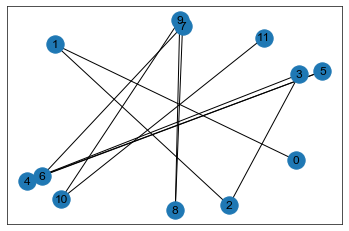

In [5]:
nx.draw_networkx(graph)

In [6]:
graph.edges.data('weight')

EdgeDataView([(0, 1, -1), (1, 2, -1), (2, 3, -1), (3, 4, -1), (4, 5, -1), (5, 6, -0.5), (6, 7, -0.5), (7, 8, -0.5), (8, 9, -0.5), (9, 10, -0.5), (10, 11, -0.5)])

In [7]:
from recirq.qaoa.classical_angle_optimization import create_ZZ_HamC

In [8]:
dense_ham = create_ZZ_HamC(graph, flag_z2_sym=False)
answer_inds = np.where(dense_ham == np.min(dense_ham))
answer_inds

(array([   0, 4095]),)

In [9]:
import scipy.optimize
from recirq.qaoa.classical_angle_optimization import optimize_instance_interp_heuristic
from recirq.qaoa.problem_circuits import get_generic_qaoa_circuit

In [10]:
oresults = optimize_instance_interp_heuristic(graph=graph, p_max=1, flag_z2_sym=True, verbose=True)
oresults

-- p=1, F = -3.859 / -8.0, nfev=5, time=0.08 s


[OptimizationResult(p=1, f_val=-3.858636906278271, gammas=[0.47364580552221963], betas=[-0.39269908169841683], min_c=array(-8.), max_c=array(8.), pzstar=0.02220457639948584)]

In [11]:
sim = cirq.Simulator()
def calc_pzstar(graph, gammas, betas):
    circuit = get_generic_qaoa_circuit(
        problem_graph=graph,
        qubits = cirq.LineQubit.range(graph.number_of_nodes()),
        gammas=gammas,
        betas=betas,
    )
    psi = sim.simulate(circuit)
    probs = np.abs(psi.final_state)**2
    np.testing.assert_allclose(np.sum(probs), 1, atol=1e-5)
    print(probs[answer_inds])

calc_pzstar(graph, oresults[-1].gammas, oresults[-1].betas)

[0.01110228 0.01110228]


In [12]:
rs = np.random.RandomState(52)
records = []
other_couplings = np.linspace(1, 0, 20)[:-1]
sim = cirq.Simulator()

for other_coupling in other_couplings:
    graph = ferry(n_qubits, rs=np.random.RandomState(52), other_coupling=other_coupling, shuff=False)
    dense_ham = create_ZZ_HamC(graph, flag_z2_sym=False, node_to_index_map={i:i for i in range(n_qubits)})
    answer_inds = np.where(dense_ham == np.min(dense_ham))
    print(other_coupling, answer_inds)
    #assert answer_inds[0].tolist() == [0, 2**n_qubits-1], answer_inds[0].tolist()
    oresults = optimize_instance_interp_heuristic(graph=graph, p_max=8, flag_z2_sym=False, verbose=True)
    
    def calc_pzstar(graph, gammas, betas):
        circuit = get_generic_qaoa_circuit(
            problem_graph=graph,
            qubits = cirq.LineQubit.range(graph.number_of_nodes()),
            gammas=gammas,
            betas=betas,
        )
        psi = sim.simulate(circuit)
        probs = np.abs(psi.final_state)**2
        np.testing.assert_allclose(np.sum(probs), 1, atol=1e-5)
        probs /= 1.0
        return np.sum(probs[answer_inds])
    
    for oresult in oresults:
        records += [{
            'other_coupling': other_coupling,
            'p': oresult.p,
            'pzstar': calc_pzstar(graph, oresult.gammas, oresult.betas),
            'f_val': oresult.f_val,
        }]

1.0 (array([   0, 4095]),)
-- p=1, F = -5.719 / -11.0, nfev=5, time=0.14 s
-- p=2, F = -7.622 / -11.0, nfev=17, time=0.08 s
-- p=3, F = -8.576 / -11.0, nfev=21, time=0.11 s
-- p=4, F = -9.171 / -11.0, nfev=22, time=0.18 s
-- p=5, F = -9.586 / -11.0, nfev=23, time=0.20 s
-- p=6, F = -9.901 / -11.0, nfev=25, time=0.27 s
-- p=7, F = -10.152 / -11.0, nfev=27, time=0.34 s
-- p=8, F = -10.357 / -11.0, nfev=30, time=0.42 s
0.9473684210526316 (array([   0, 4095]),)
-- p=1, F = -5.553 / -10.684210526315791, nfev=5, time=0.11 s
-- p=2, F = -7.401 / -10.684210526315791, nfev=17, time=0.06 s
-- p=3, F = -8.330 / -10.684210526315791, nfev=21, time=0.11 s
-- p=4, F = -8.912 / -10.684210526315791, nfev=23, time=0.16 s
-- p=5, F = -9.318 / -10.684210526315791, nfev=23, time=0.22 s
-- p=6, F = -9.614 / -10.684210526315791, nfev=24, time=0.28 s
-- p=7, F = -9.852 / -10.684210526315791, nfev=26, time=0.33 s
-- p=8, F = -10.047 / -10.684210526315791, nfev=29, time=0.40 s
0.8947368421052632 (array([   0, 4

-- p=5, F = -5.199 / -6.263157894736841, nfev=23, time=0.23 s
-- p=6, F = -5.499 / -6.263157894736841, nfev=29, time=0.35 s
-- p=7, F = -5.718 / -6.263157894736841, nfev=44, time=0.62 s
-- p=8, F = -5.793 / -6.263157894736841, nfev=40, time=0.63 s
0.1578947368421053 (array([   0, 4095]),)
-- p=1, F = -2.858 / -5.947368421052632, nfev=5, time=0.14 s
-- p=2, F = -3.829 / -5.947368421052632, nfev=14, time=0.06 s
-- p=3, F = -4.364 / -5.947368421052632, nfev=18, time=0.11 s
-- p=4, F = -4.778 / -5.947368421052632, nfev=20, time=0.16 s
-- p=5, F = -5.052 / -5.947368421052632, nfev=23, time=0.23 s
-- p=6, F = -5.281 / -5.947368421052632, nfev=28, time=0.34 s
-- p=7, F = -5.472 / -5.947368421052632, nfev=51, time=0.71 s
-- p=8, F = -5.555 / -5.947368421052632, nfev=49, time=0.78 s
0.10526315789473695 (array([   0, 4095]),)
-- p=1, F = -2.790 / -5.631578947368423, nfev=5, time=0.12 s
-- p=2, F = -3.748 / -5.631578947368423, nfev=15, time=0.06 s
-- p=3, F = -4.278 / -5.631578947368423, nfev=19,

In [19]:
import pandas as pd

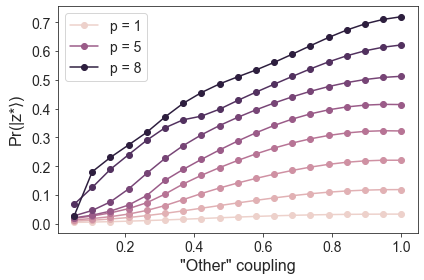

In [20]:
df = pd.DataFrame(records)
ps = sorted(df['p'].unique())

for p, color in zip(ps, sns.cubehelix_palette(n_colors=len(ps))):
    df0 = df.copy()
    df = df[df['p'] == p]
    if p in [ps[0], ps[len(ps)//2], ps[-1]]:
        label = f'p = {p}'
    else:
        label = None
    plt.plot(df['other_coupling'], df['pzstar'], 'o-', label=label, color=color)

    df = df0


plt.xlabel('"Other" coupling')
plt.ylabel(r'Pr(|z*$\rangle $)')

plt.legend(loc='best')
plt.tight_layout()

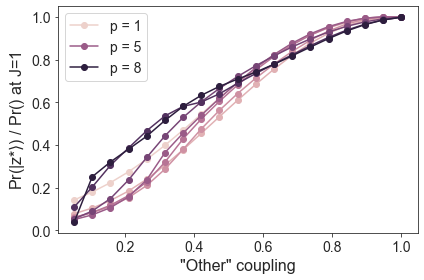

In [21]:
df = pd.DataFrame(records)
ps = sorted(df['p'].unique())

for p, color in zip(ps, sns.cubehelix_palette(n_colors=len(ps))):
    df0 = df.copy()
    df = df[df['p'] == p]
    df = df.sort_values(by='other_coupling')
    if p in [ps[0], ps[len(ps)//2], ps[-1]]:
        label = f'p = {p}'
    else:
        label = None
    plt.plot(df['other_coupling'], df['pzstar']/df.iloc[-1]['pzstar'], 'o-', label=label, color=color)
    df = df0
    
plt.xlabel('"Other" coupling')
plt.ylabel(r'Pr(|z*$\rangle $) / Pr() at J=1')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
# flat_records = []
# for record in records:
#     for m in record['marginals']:
#         flat_records.append({'scale': record['scale'], 'm': m})
# df = pd.DataFrame(flat_records)
# #sns.swarmplot(df['scale'], np.abs(df['m']))
# plt.scatter(df['scale'], np.abs(df['m']))

In [12]:
flat_records = []
for record in records:
    flat_records.append({
        'scale': record['scale'], 
        'maxm': max(np.abs(record['marginals'])),
        'p': record['p'],
    })
    
df = pd.DataFrame(flat_records)
#sns.swarmplot(df['scale'], np.abs(df['maxm']))
for p in [1, 2]:
    df0 = df.copy()
    df = df[df['p'] == p]
    plt.scatter(df['scale'], np.abs(df['maxm']))

    dfg = df.groupby('scale').agg('mean').reset_index()
    plt.plot(dfg['scale'], dfg['maxm'], label=f'p = {p}')
    
    df = df0

plt.xlabel('One/Two-body strength ratio')
plt.ylabel(r'Max $|\langle Z \rangle|$')
plt.legend(loc='best')
plt.xscale('log', basex=2)

NameError: name 'records' is not defined

In [13]:
def integrate_out(graph, i_remove, i_set):
    new_g = nx.Graph()
    offset = 0
    for i, w in graph.nodes.data('weight'):
        if w is None:
            w = 0
        if i == i_remove:
            offset += w*i_set
        else:
            new_g.add_node(i, weight=w)
    for i1, i2, w in graph.edges.data('weight'):
        if i1 == i_remove:
            new_g.nodes[i2]['weight'] += i_set * w
        elif i2 == i_remove:
            new_g.nodes[i1]['weight'] += i_set * w
        else:
            new_g.add_edge(i1, i2, weight=w)
            
    new_to_old = sorted(new_g.nodes)
    new_g = nx.relabel_nodes(new_g, {new_to_old[i]: i for i in range(new_g.number_of_nodes())})
    return new_g, offset, new_to_old

In [14]:
graph = nx.complete_graph(3)
graph = random_plus_minus_1_weights(graph, rs=np.random.RandomState(52))
nx.set_node_attributes(graph, values=0.5, name='weight')
graph.edges.data('weight')

EdgeDataView([(0, 1, 1), (0, 2, -1), (1, 2, 1)])

In [15]:
new_g, ofst, new_to_old = integrate_out(graph, 0, 1)
new_g.edges.data('weight')

EdgeDataView([(0, 1, 1)])

In [16]:
new_g.nodes.data('weight')

NodeDataView({0: 1.5, 1: -0.5}, data='weight')

In [17]:
ofst

0.5

In [18]:
new_to_old

[1, 2]

In [31]:
def print_graph_eqn(graph, offset):
    s = []
    for n1, n2, w in graph.edges.data('weight'):
        s += [f'{w:.2f}*Z{n1}Z{n2}']
    for n, w in graph.nodes.data('weight'):
        s += [f'{w:.2f}*Z{n}']
    s += [f'{offset:.2f}']
    return ' + '.join(s)

In [85]:
rs = np.random.RandomState(52)
records = []
n_qubits = 16
#     papa_graph = nx.complete_graph(n_qubits)
#     papa_graph = random_plus_minus_1_weights(papa_graph, rs=rs)
papa_graph = nx.random_regular_graph(3, n_qubits, seed=rs)
nx.set_edge_attributes(papa_graph, values=1, name='weight')
graph = papa_graph.copy()
nx.set_node_attributes(
    graph, values={
        i: val
        for i, val in enumerate(rs.normal(scale=0.1, size=graph.number_of_nodes()))},
        #for i, val in enumerate(rs.choice([1, -1], size=graph.number_of_nodes()))},
    name='weight')

HamC = create_ZZ_HamC(graph, flag_z2_sym=False,
                      node_to_index_map=None, dtype=np.complex128)
min_c = np.real_if_close(np.min(HamC))
print("!!", min_c, "!!")

records = []
offset = 0
while True:
    oresults = optimize_instance_interp_heuristic(graph=graph, p_max=1, flag_z2_sym=False, verbose=True)
    oresult = oresults[-1]
    print("sumfval", oresult.f_val + offset)
    print("    (offset)", offset)
    records += [{
        'n': graph.number_of_nodes(),
        'f_val': oresult.f_val + offset,
        'offset': offset,
    }]
    
    if graph.number_of_nodes() == 0:
        break
    marginals = calc_marginals(graph, oresult.gammas, oresult.betas)
    marginals = np.asarray(marginals)
    print('marginal', np.round(marginals, 3))
    fixi = np.argmax(np.abs(marginals))
    print('fixing', fixi, marginals[fixi])
    if not np.abs(marginals[fixi])>0:
        print("Could not fix actually")
        break
    graph, ofst, mapping = integrate_out(graph, fixi, 1 if marginals[fixi]>0 else -1)
    offset += ofst
    print(print_graph_eqn(graph, offset))


!! -18.025818097460412 !!
-- p=1, F = -8.334 / -18.025818097460412, nfev=10, time=3.01 s
sumfval -8.333843778575968
    (offset) 0
marginal [ 0.008  0.001 -0.014 -0.011 -0.016 -0.014 -0.012  0.042  0.038  0.03
 -0.013  0.008 -0.016  0.001  0.042  0.028]
fixing 7 0.04221887141466141
1.00*Z3Z14 + 1.00*Z3Z10 + 1.00*Z3Z7 + 1.00*Z14Z7 + 1.00*Z14Z5 + 1.00*Z4Z5 + 1.00*Z4Z10 + 1.00*Z2Z7 + 1.00*Z2Z11 + 1.00*Z2Z10 + 1.00*Z0Z13 + 1.00*Z0Z12 + 1.00*Z0Z6 + 1.00*Z13Z6 + 1.00*Z13Z11 + 1.00*Z5Z12 + 1.00*Z12Z9 + 1.00*Z11Z1 + 1.00*Z1Z9 + 1.00*Z1Z8 + 1.00*Z9Z8 + 0.05*Z3 + -0.12*Z14 + 1.07*Z4 + 0.06*Z2 + -0.17*Z7 + -0.04*Z0 + -0.18*Z13 + -0.04*Z10 + 0.06*Z5 + -0.00*Z12 + 0.07*Z11 + 1.05*Z6 + -0.00*Z1 + 0.06*Z9 + 0.87*Z8 + -0.19
-- p=1, F = -7.965 / -17.83948889625718, nfev=11, time=1.38 s
sumfval -8.151569524287908
    (offset) -0.18632920120323337
marginal [ 0.008  0.001 -0.014 -0.012 -0.279 -0.014 -0.275  0.038 -0.231 -0.013
  0.008 -0.016  0.001  0.042  0.029]
fixing 4 -0.2790922522544861
1.00*Z3Z13 + 

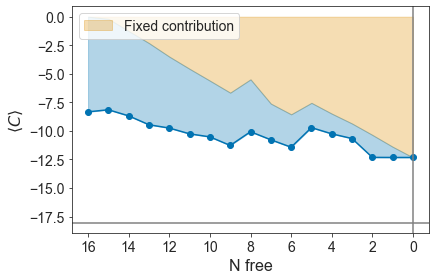

In [86]:
df = pd.DataFrame(records)
plt.plot(-df['n'], df['f_val'], 'o-', color=sns.color_palette()[0])
plt.fill_between(-df['n'], df['offset'], color=sns.color_palette()[1], alpha=0.3, label='Fixed contribution')
plt.fill_between(-df['n'], df['f_val'], df['offset'], color=sns.color_palette()[0], alpha=0.3)
plt.xlabel('N free')
plt.axvline(0, color='grey')
plt.axhline(min_c, color='grey')
plt.legend(loc='best')
plt.ylabel(r'$\langle C \rangle$')
plt.xticks(list(range(-n_qubits, 0+1, 2)), [-n for n in range(-n_qubits, 0+1, 2)])
plt.tight_layout()


In [87]:
sim = cirq.Simulator()

def expectation(graph, gammas, betas):
    ret = 0
    psi = sim.simulate(get_generic_qaoa_circuit(
            problem_graph=graph,
            qubits = cirq.LineQubit.range(graph.number_of_nodes()),
            gammas=gammas,
            betas=betas,
    ))
    for i1, i2, w in graph.edges.data('weight'):
        zz_val = w * (cirq.Z(cirq.LineQubit(i1)) * cirq.Z(cirq.LineQubit(i2)))\
                             .expectation_from_wavefunction(psi.final_state, psi.qubit_map)
        assert zz_val.imag < 1e-6, zz_val
        zz_val = zz_val.real
        ret += zz_val
    for i1, w in graph.nodes.data('weight'):
        z_val = w * (cirq.Z(cirq.LineQubit(i1))) \
                             .expectation_from_wavefunction(psi.final_state, psi.qubit_map)
        assert z_val.imag < 1e-6, z_val
        z_val = z_val.real
        ret += z_val
    return ret

In [88]:
expectation(graph, oresults[-1].gammas, oresults[-1].betas), oresults[-1].f_val

(0, 0.0)